# 1. Imports

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
tf.random.set_seed(329)


# 2. Helper Functions

In [35]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['binary_accuracy']
  val_accuracy = history.history['val_binary_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();



def show_data(image_batch, label_batch,dataset_name):
    plt.figure(figsize=(15, 6))
    plt.suptitle(dataset_name, fontsize=16)
    for n in range(10):
        ax = plt.subplot(2, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["binary_accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_binary_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["binary_accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_binary_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# 3. Exploring and Loading the data

In [3]:
for dirpath, dirnames, filenames in os.walk(r"C:\\Users\\User\\Downloads\\archive\\chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
     

There are 5 directories and 0 images in 'C:\\Users\\User\\Downloads\\archive\\chest_xray'.
There are 3 directories and 1 images in 'C:\\Users\\User\\Downloads\\archive\\chest_xray\chest_xray'.
There are 2 directories and 1 images in 'C:\\Users\\User\\Downloads\\archive\\chest_xray\chest_xray\test'.
There are 0 directories and 234 images in 'C:\\Users\\User\\Downloads\\archive\\chest_xray\chest_xray\test\NORMAL'.
There are 0 directories and 390 images in 'C:\\Users\\User\\Downloads\\archive\\chest_xray\chest_xray\test\PNEUMONIA'.
There are 2 directories and 1 images in 'C:\\Users\\User\\Downloads\\archive\\chest_xray\chest_xray\train'.
There are 0 directories and 1342 images in 'C:\\Users\\User\\Downloads\\archive\\chest_xray\chest_xray\train\NORMAL'.
There are 0 directories and 3876 images in 'C:\\Users\\User\\Downloads\\archive\\chest_xray\chest_xray\train\PNEUMONIA'.
There are 2 directories and 1 images in 'C:\\Users\\User\\Downloads\\archive\\chest_xray\chest_xray\val'.
There are 0 

In [4]:
train_dir = r"C:\\Users\\User\\Downloads\\archive\\chest_xray\\train"
test_dir = r"C:\\Users\\User\\Downloads\\archive\\chest_xray\\test"
val_dir = r"C:\\Users\\User\\Downloads\\archive\\chest_xray\\val"
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
                rescale=1. / 255,
                horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1. / 255)
test_gen = ImageDataGenerator(rescale=1. / 255)

In [5]:
train_data= train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = True)
val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary')
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


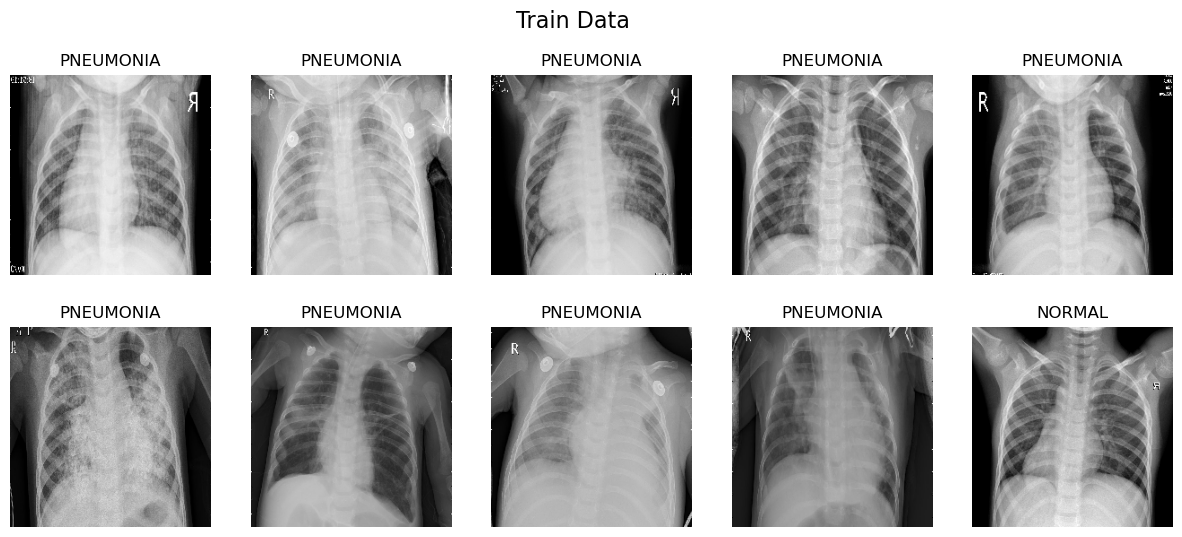

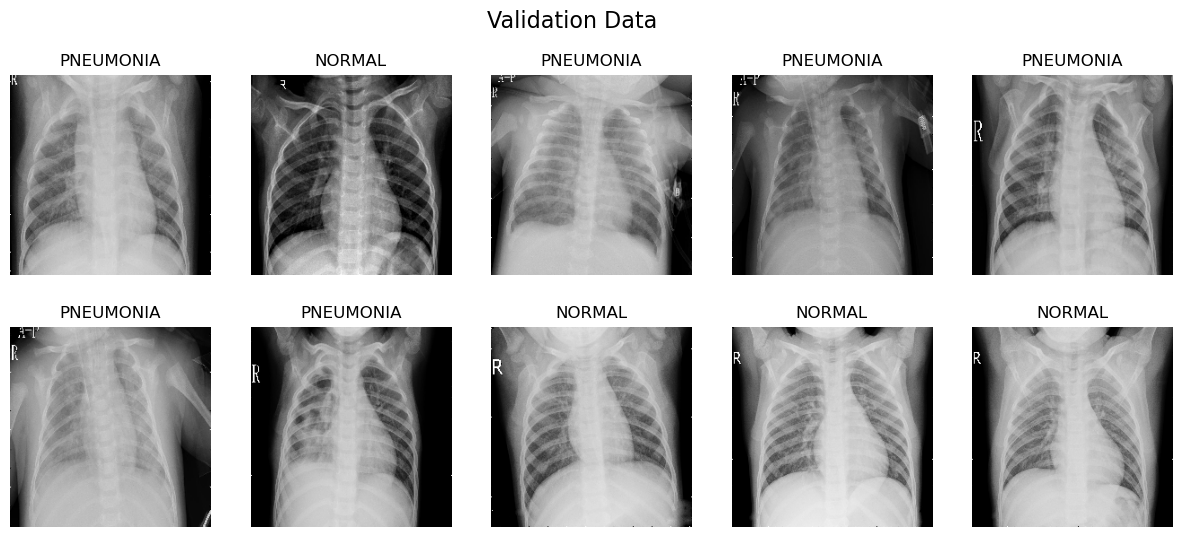

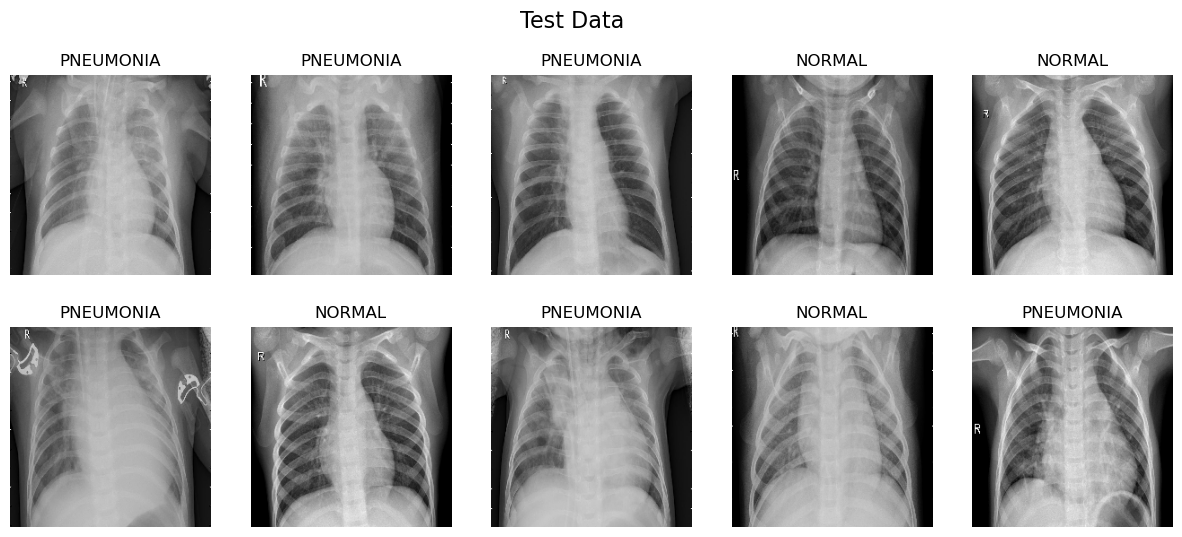

In [6]:
train_batch, train_batch_label = next(iter(train_data))
show_data(train_batch, train_batch_label,'Train Data')
val_batch, val_batch_label = next(iter(val_data))
show_data(val_batch, val_batch_label,'Validation Data')
test_batch, test_batch_label = next(iter(test_data))
show_data(test_batch, test_batch_label,'Test Data')

# 4. Defining the callbacks

In [7]:
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=5,
                              min_delta=1e-7,
                              restore_best_weights=True,
)


# 5. Transfer Learning

# 5.1. Feature Extraction

In [8]:
input_shape=(224,224,3)

base_model = tf.keras.applications.DenseNet121(include_top=False,input_shape=input_shape)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=input_shape,name='input_layer')

base_model = base_model(inputs)
base_model = tf.keras.layers.GlobalAveragePooling2D()(base_model)

outputs = tf.keras.layers.Dense(1, activation = 'sigmoid',dtype=tf.float32)(base_model)

model = tf.keras.models.Model(inputs = inputs, outputs = outputs)

In [9]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["binary_accuracy"])

## Model Summary

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7038529 (26.85 MB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [11]:
history = model.fit(train_data,
         epochs=10,
         validation_data = test_data,
         callbacks = [model_checkpoint,early_stopping])

Epoch 1/10
163/163 [==============================] - 965s 6s/step - loss: 0.6670 - binary_accuracy: 0.6300 - val_loss: 0.6771 - val_binary_accuracy: 0.6218
Epoch 2/10
163/163 [==============================] - 936s 6s/step - loss: 0.4944 - binary_accuracy: 0.7625 - val_loss: 0.5911 - val_binary_accuracy: 0.6410
Epoch 3/10
163/163 [==============================] - 941s 6s/step - loss: 0.4184 - binary_accuracy: 0.8119 - val_loss: 0.5617 - val_binary_accuracy: 0.6554
Epoch 4/10
163/163 [==============================] - 930s 6s/step - loss: 0.3616 - binary_accuracy: 0.8464 - val_loss: 0.5112 - val_binary_accuracy: 0.7051
Epoch 5/10
163/163 [==============================] - 928s 6s/step - loss: 0.3188 - binary_accuracy: 0.8811 - val_loss: 0.4773 - val_binary_accuracy: 0.7308
Epoch 6/10
163/163 [==============================] - 895s 5s/step - loss: 0.2882 - binary_accuracy: 0.9030 - val_loss: 0.4804 - val_binary_accuracy: 0.7260
Epoch 7/10
163/163 [==============================] - 5868

In [12]:
model.evaluate(test_data)

20/20 [==============================] - 100s 5s/step - loss: 0.4318 - binary_accuracy: 0.7676


[0.43180906772613525, 0.7676281929016113]

# 5.2. Visualizing

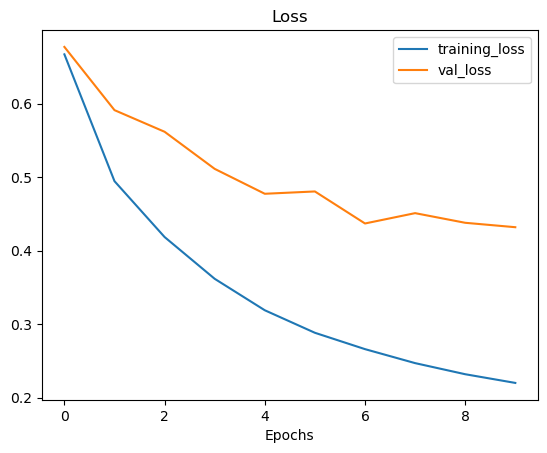

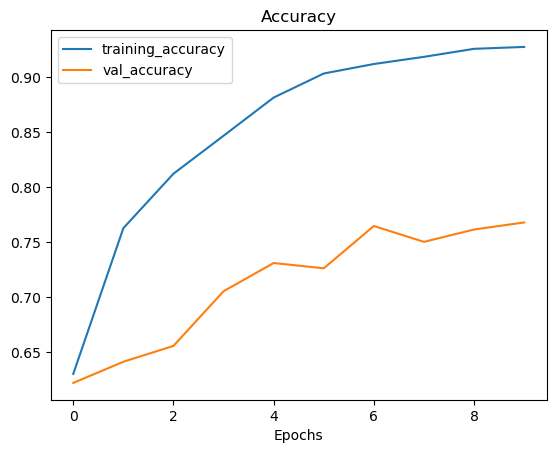

In [13]:
plot_loss_curves(history)

# 5.3. Fine Tunning

In [14]:
base_model.trainable = True
for layer in model.layers[1].layers[:-5]:
    layer.trainable = False

In [27]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["binary_accuracy"])

In [28]:
checkpoint_path = "model_checkpoints/cp_fine_tunning.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_binary_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True, 
                                                      verbose=0)

In [30]:
history_fine_tune = model.fit(train_data,
                            epochs=20, 
                            validation_data=test_data,
                            initial_epoch=history.epoch[-1],
                            callbacks=[model_checkpoint,early_stopping])

Epoch 10/20
163/163 [==============================] - 978s 6s/step - loss: 0.1851 - binary_accuracy: 0.9383 - val_loss: 0.4151 - val_binary_accuracy: 0.7804
Epoch 11/20
163/163 [==============================] - 949s 6s/step - loss: 0.1840 - binary_accuracy: 0.9348 - val_loss: 0.4136 - val_binary_accuracy: 0.7821
Epoch 12/20
163/163 [==============================] - 925s 6s/step - loss: 0.1827 - binary_accuracy: 0.9396 - val_loss: 0.4153 - val_binary_accuracy: 0.7804
Epoch 13/20
163/163 [==============================] - 967s 6s/step - loss: 0.1837 - binary_accuracy: 0.9369 - val_loss: 0.4124 - val_binary_accuracy: 0.7837
Epoch 14/20
163/163 [==============================] - 959s 6s/step - loss: 0.1813 - binary_accuracy: 0.9356 - val_loss: 0.4121 - val_binary_accuracy: 0.7837
Epoch 15/20
163/163 [==============================] - 944s 6s/step - loss: 0.1794 - binary_accuracy: 0.9375 - val_loss: 0.4106 - val_binary_accuracy: 0.7837
Epoch 16/20
163/163 [==============================]

# 5.4. Visulaizing

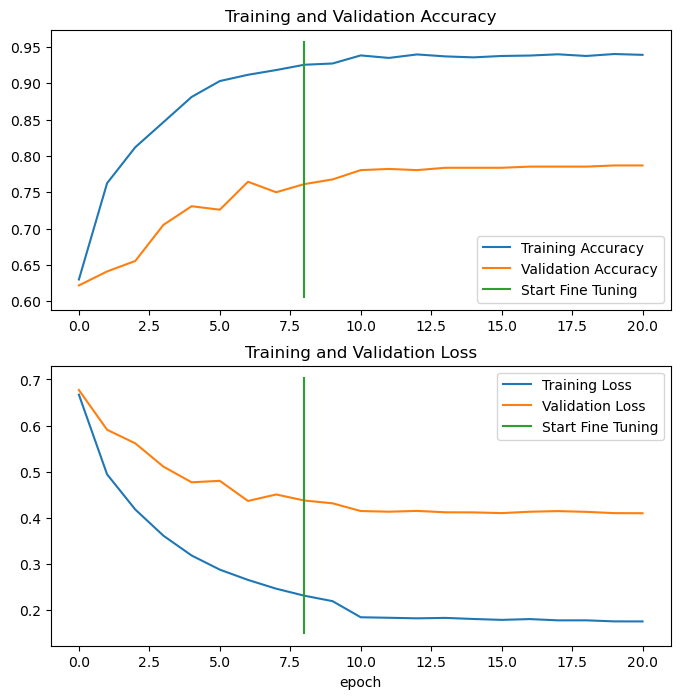

In [31]:
compare_historys(history,history_fine_tune,history.epoch[-1])

In [32]:
model.evaluate(test_data)

20/20 [==============================] - 99s 5s/step - loss: 0.4103 - binary_accuracy: 0.7869


[0.41028907895088196, 0.7868589758872986]